## 1. Просмотр и подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import datetime as dt
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats as st

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [5]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


**ВЫВОД:** Пропусков в данных нет. Данные с датами переведем в формат даты. С возможными выбросами в данных разберемся в процессе анализа.

In [6]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

## 2. Анализ гипотез

Найдем приоритетные гипотезы двумя методами, ICE и RICE. 

Для начала расчитаем ICE и RICE. Выведем отсортированные таблицы с результатом.

In [7]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['ICE']

In [8]:
hypothesis[['Hypothesis', 'ICE']].sort_values(by = 'ICE',  ascending = False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


In [9]:
hypothesis[['Hypothesis', 'RICE']].sort_values(by = 'RICE',  ascending = False)

,Hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


Присвоим каждой гипотезе свой ID - для лучшей визуализации графика. 

In [10]:
hypothesis['hypothesis_id'] = [1, 2, 3, 4, 5, 6, 7, 8, 9]

In [11]:
hypothesis[['Hypothesis', 'hypothesis_id']]

,Hypothesis,hypothesis_id
0,"Добавить два новых канала привлечения трафика,...",1
1,"Запустить собственную службу доставки, что сок...",2
2,Добавить блоки рекомендаций товаров на сайт ин...,3
3,"Изменить структура категорий, что увеличит кон...",4
4,"Изменить цвет фона главной страницы, чтобы уве...",5
5,"Добавить страницу отзывов клиентов о магазине,...",6
6,Показать на главной странице баннеры с актуаль...,7
7,Добавить форму подписки на все основные страни...,8
8,"Запустить акцию, дающую скидку на товар в день...",9


Для построения графика пересортируем таблицу с результатами в столбик. Построим график.

In [12]:
hypothesis_ICE = hypothesis[['Hypothesis','hypothesis_id', 'ICE']].copy()
hypothesis_ICE.loc[:, 'framework'] = 'ICE'
hypothesis_ICE.columns = ['Hypothesis','hypothesis_id', 'value', 'framework']

hypothesis_RISE = hypothesis[['Hypothesis','hypothesis_id', 'RICE']].copy()
hypothesis_RISE.loc[:, 'framework'] = 'RICE'
hypothesis_RISE.columns = ['Hypothesis','hypothesis_id', 'value', 'framework']

hypothesis_frameworks = pd.concat([hypothesis_ICE, hypothesis_RISE]).reset_index(drop = True)

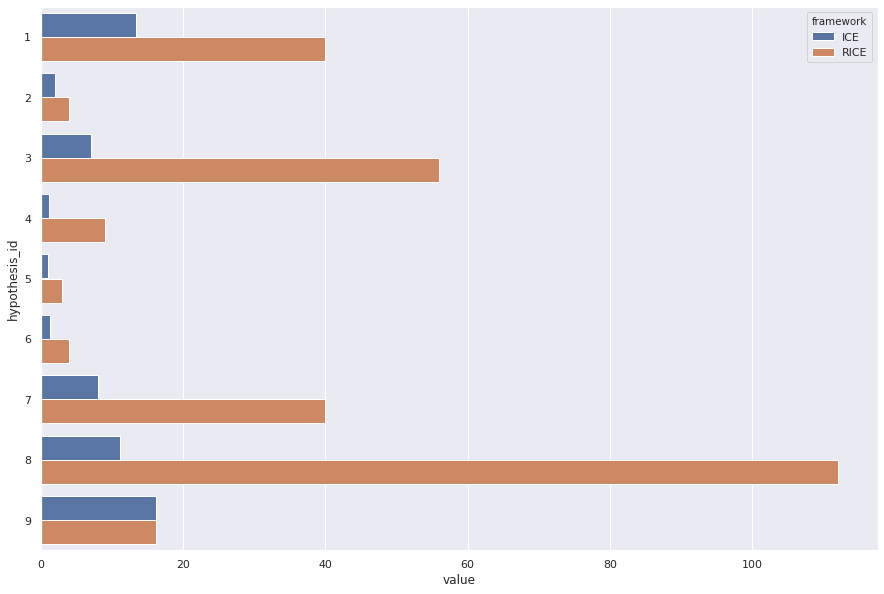

In [13]:
sns.set(rc={'figure.figsize':(15,10)})
ax = sns.barplot(x= 'value', y='hypothesis_id', ci=False, hue = 'framework', orient = 'h', data = hypothesis_frameworks) 


**ВЫВОД:**

По таблицам и графику видно что показателю ICE в приоритете гипотезы №9, №1, №3 и далее по убыванию.

Больший охват пользователей изменяет приоритет по показателю RICE в пользу гипотез №8, №3 №1, №7 и далее по убыванию.

Гипотезы №2, №4, №5, №6 можно отбросить т.к. они в "аутсайдерах" по двум методам.

## 3. Анализ A/B-теста

### 3.1 Подготовка данных для графиков.

Найдем даты с заказами, для каждой группы.

In [14]:
datesGroups = orders[['date','group']].drop_duplicates()
datesGroups.sample(5)

,date,group
86,2019-08-22,A
181,2019-08-23,B
55,2019-08-01,A
789,2019-08-08,B
567,2019-08-09,B


Получим агрегированные кумулятивные по дням данные: количество транзакций, количество уникальных покупателей, общую сумму заказа.

In [15]:
datesGroups = orders[['date','group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionId' : pd.Series.nunique,
'visitorId' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

Получим агрегированные кумулятивные по дням данные по количеству посетителей

In [16]:
visitorsAggregated = datesGroups.apply(
lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

Обьеденим данные, изменим названия столбцов.

In [17]:
cummulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cummulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [18]:
cummulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


### 3.2 График кумулятивной выручки по группам.

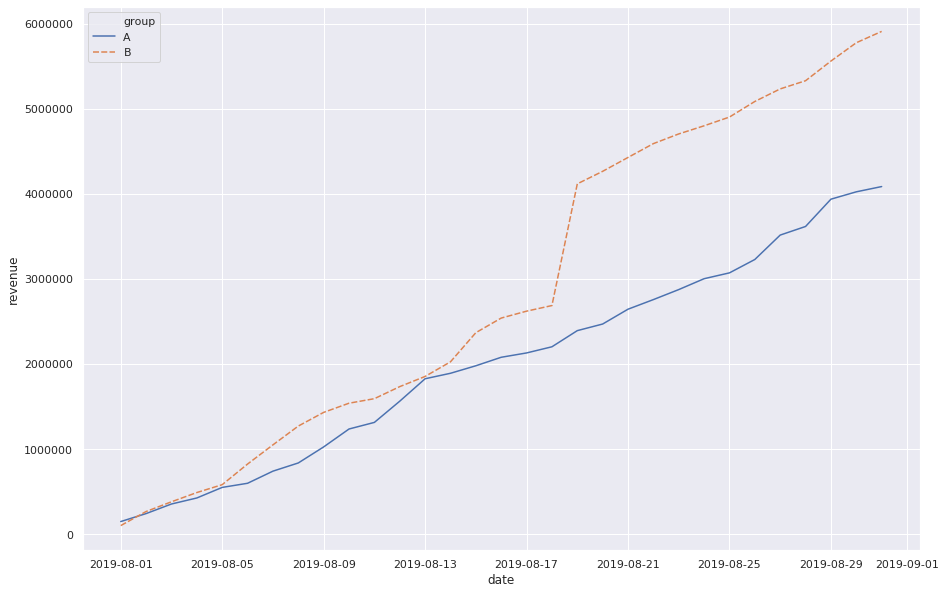

In [44]:
sns.set(rc={'figure.figsize':(15,10)})

ax = sns.lineplot(x='date', y='revenue', hue = 'group', style = 'group', data = cummulativeData, ci=None)

**ВЫВОД:** Графики обеих групп растут вверх. Кумулятивная выручка примерно одинакова до 2019-08-18. Далее в данных группы "В" имеется выброс на 2019-08-18 число.

### 3.3 График кумулятивного среднего чека по группам.

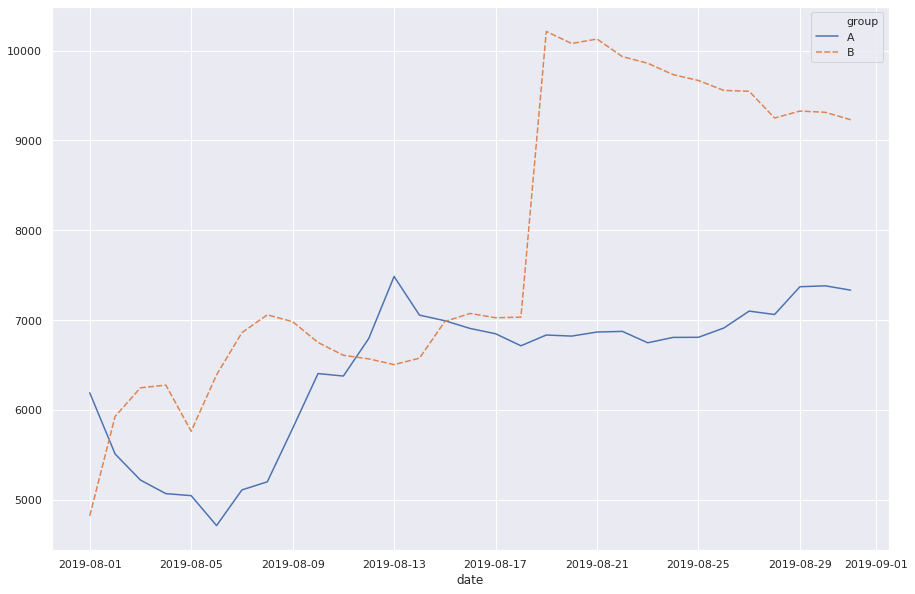

In [20]:
sns.set(rc={'figure.figsize':(15,10)})

ax = sns.lineplot(x='date', y=cummulativeData['revenue']/cummulativeData['orders'],
                  hue = 'group', style = 'group', data = cummulativeData, ci=None)

**ВЫВОД:** Средний чек группы А становится более менее равномерным к концу теста. По группе "В" сказать сложно т.к. имеется выброс на 2019-08-18 число.

### 3.4 График относительного различия для среднего чека.

Создадим таблицу где на каждую дату будет указано кол-во заказов и чек по каждой группе.

In [21]:
cummulativeRevenueA = cummulativeData[cummulativeData['group']=='A'][['date','revenue', 'orders']]

cummulativeRevenueB = cummulativeData[cummulativeData['group']=='B'][['date','revenue', 'orders']]

mergedCummulativeRevenue = cummulativeRevenueA.merge(cummulativeRevenueB, left_on='date', right_on='date', 
                                                     how='left', suffixes=['A', 'B'])

In [22]:
mergedCummulativeRevenue.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


Построим график

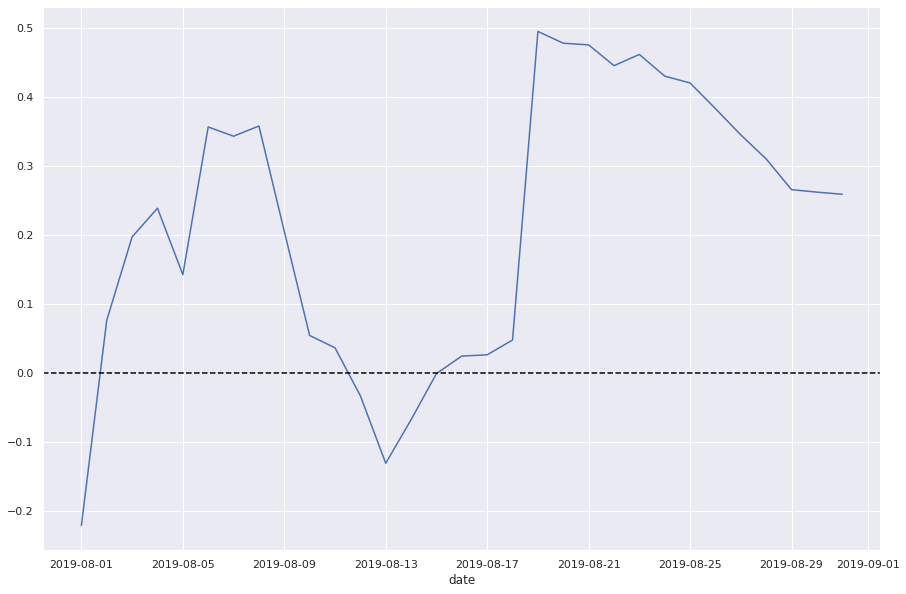

In [23]:
sns.set(rc={'figure.figsize':(15,10)})


ax = sns.lineplot(x = mergedCummulativeRevenue['date'],
                  y=(mergedCummulativeRevenue['revenueB']/mergedCummulativeRevenue['ordersB'])
                    /(mergedCummulativeRevenue['revenueA']/mergedCummulativeRevenue['ordersA'])-1,
                  data = mergedCummulativeRevenue, ci=None)

plt.axhline(y=0, color='black', linestyle='--')

**ВЫВОД:** Про относительное различие в среднем чеке сложно что-то сказать т.к. в нескольких точках график резко «скачет». По-видимому есть выбросы по заказам.

### 3.5 График кумулятивной конверсии.

Расчитаем кумулятивную конверсию.

In [24]:
cummulativeData['conversion'] = cummulativeData['orders']/cummulativeData['visitors']

Построим график.

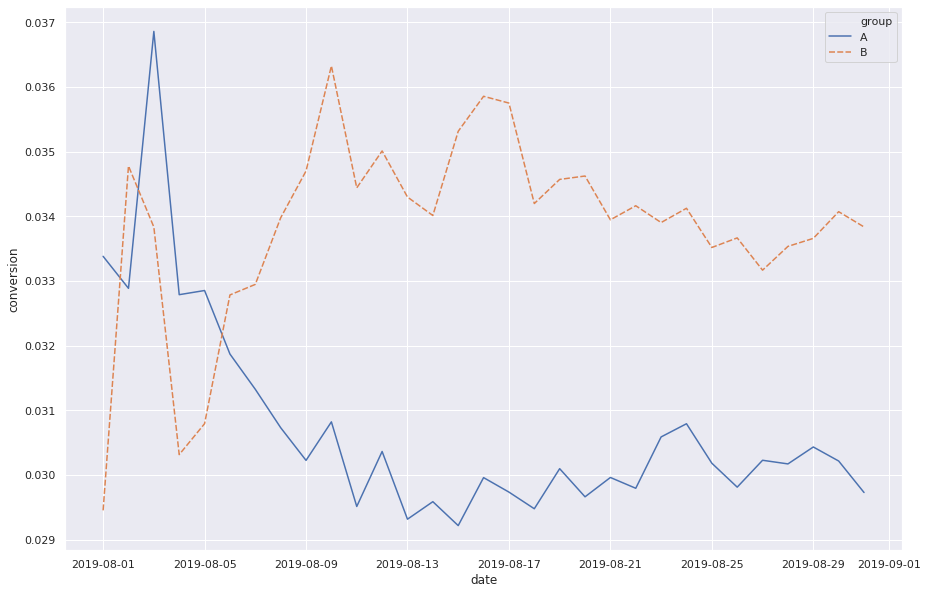

In [25]:
ax = sns.lineplot(x='date', y='conversion', hue = 'group', style = 'group', data = cummulativeData, ci=None)

**ВЫВОД:** Конверсии в конце эксперимента немного зафиксировались, Конверсия группы В, выше прмерно на 10%

### 3.6 График относительного изменения кумулятивной конверсии группы B к группе A

Создадим таблицу c кумулятивными конверсиями по группам.

In [26]:
cummulativeDataA = cummulativeData[cummulativeData['group']=='A']

cummulativeDataB = cummulativeData[cummulativeData['group']=='B']

mergedCummulativeConversions = cummulativeDataA[['date','conversion']].merge(cummulativeDataB[['date','conversion']],
    left_on='date', right_on='date',how='left', suffixes=['A', 'B'])

In [27]:
mergedCummulativeConversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


Построим график.

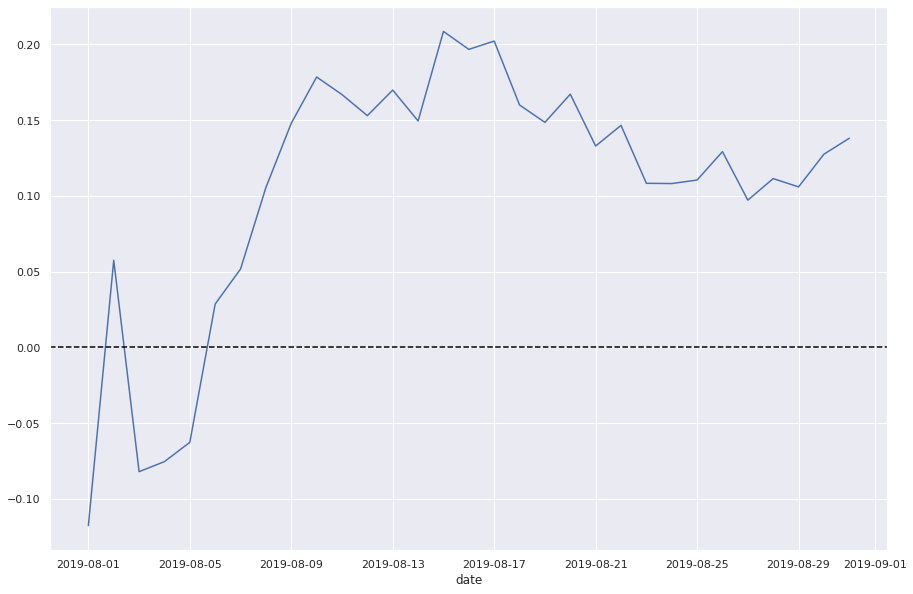

In [28]:
sns.set(rc={'figure.figsize':(15,10)})

ax = sns.lineplot(x = mergedCummulativeConversions['date'],
                  y=mergedCummulativeConversions['conversionB']/mergedCummulativeConversions['conversionA']-1,
                  data = mergedCummulativeRevenue, ci=None)

plt.axhline(y=0, color='black', linestyle='--')

**ВЫВОД:** Конверсия группы В псле колебаний в первые дни, вышла вперед по отношению к конверсии группы А. В конце теста наблюдалось некоторое снижение конверсии группы В по отношению к группе А.

### 3.7 Точечный график количества заказов по пользователям.

Сгруппируем заказы по по пользователям.

In [29]:
ordersByUsers = orders[['visitorId', 'transactionId']].groupby('visitorId').agg({'transactionId': 'nunique'}).reset_index()

Построим график

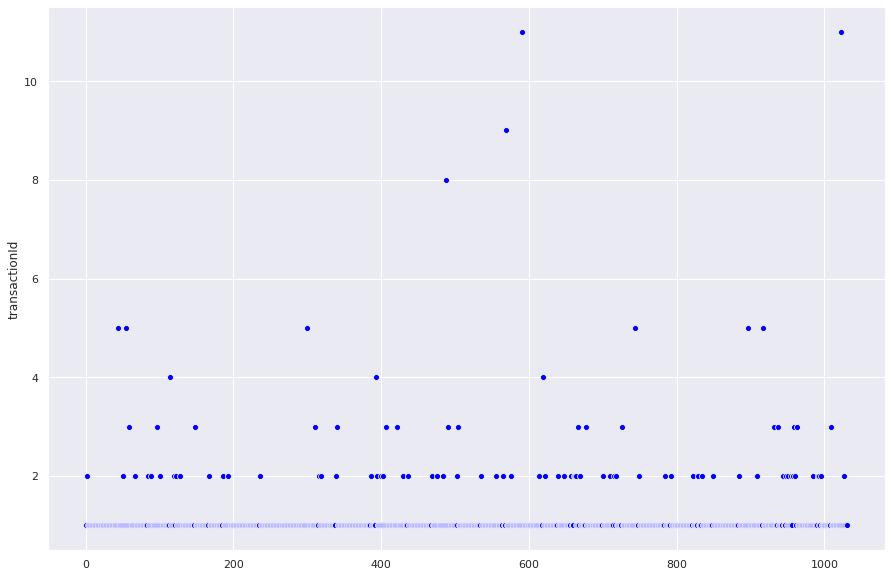

In [30]:
ax = sns.scatterplot(x=range(0,len(ordersByUsers)), y=ordersByUsers['transactionId'], data=orders, color = 'blue')

Посмортим на описание данных о количесве заказов.  Добавим в вывод 95% и 99% перцентили.

In [31]:
ordersByUsers['transactionId'].describe(percentiles = [0.25, 0.5, 0.75, 0.95, 0.99])

count    1031.000000
mean        1.161009
std         0.724919
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
95%         2.000000
99%         4.000000
max        11.000000
Name: transactionId, dtype: float64

**ВЫВОД** Среднее значение смещено в "+" относительно медианы - есть большие выбросы. Максимальное значение аж в 11 раз больше среднего. 95% и 99% всей выборки укладываются в пределы двух и четырех заказов соответствено. Количество пользователей с заказами больше 4 можно считать выбросами. Их менее 1%

### 3.8 Точечный график стоимостей заказов.

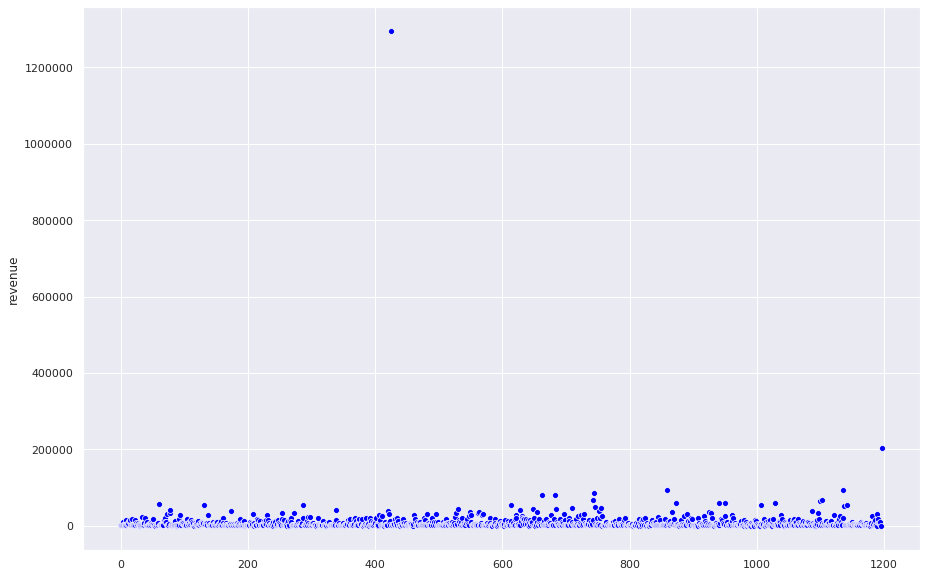

In [32]:
ax = sns.scatterplot(x=range(0,len(orders)), y=orders['revenue'], data=orders, color = 'blue')

Посмортим на описание данных о количесве заказов. Добавим в вывод  95% 99% перцентили.

In [33]:
orders['revenue'].describe(percentiles = [0.25, 0.5, 0.75, 0.95, 0.99])

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
95%      2.800000e+04
99%      5.823320e+04
max      1.294500e+06
Name: revenue, dtype: float64

**ВЫВОД:** Есть небольшое кол-во заказов с аномально большой стоимостью. Это заказы стоимостью выше 30000, которые составляют менее 5% от всех заказов. Будем считать их выбросами.

### 3.9 Проверка статистической значимости различий в конверсии между группами по «сырым» данным.

Создадим для двух групп таблицу с количеством заказов на каждого пользователя

In [34]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})

Посчитаем количество пользователей обеих групп, не совершивших заказ

In [35]:
count_usersA_without_purchase = visitors.query('group == "A" ')['visitors'].sum() - len(ordersByUsersA)

count_usersB_without_purchase = visitors.query('group == "B" ')['visitors'].sum() - len(ordersByUsersB)

Обьеденим для обеих групп списки, где каждый элемент списка - количество заказов каждого пользователя, в том числе и пользователей с нулем заказов. 

In [36]:
ordersByUsersA_list = ordersByUsersA['transactionId'].values.tolist()

for i in range (0, count_usersA_without_purchase):
    ordersByUsersA_list.append(0)

    
ordersByUsersB_list = ordersByUsersB['transactionId'].values.tolist()

for i in range (0, count_usersB_without_purchase):
    ordersByUsersB_list.append(0)

Проверим статистическую значимость между двумя группами. Критический уровень статистической значимости установим 0.5


Нулевая гипотеза - нет статистически значимой разницы между конверсиями двух групп.

Альтернативная гипотеза - есть статистически значимая разница между конверсиями двух групп.

In [37]:
alpha = .05

results = st.mannwhitneyu(ordersByUsersA_list, ordersByUsersB_list)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")
    
print("Средняя конверсия группы В / Средняя конверсия группы А =  {0:.3f}"
      .format( (sum(ordersByUsersB_list)/len(ordersByUsersB_list))
              /(sum(ordersByUsersA_list)/len(ordersByUsersA_list))-1)
     )

p-значение:  0.008396177528376304
Отвергаем нулевую гипотезу: разница статистически значима
Средняя конверсия группы В / Средняя конверсия группы А =  0.138


**ВЫВОД:** По сырым данным ЕСТЬ статистически значимое различие между конверсиями групп. Частное от средних показывает что разница в 15% в пользу группы В.

### 3.10 Проверка статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.

Проверим статистическую значимость между двумя группами. Критический уровень статистической значимости установим 0.5


Нулевая гипотеза - нет статистически значимой разницы в среднем чеке между  двумя группами.

Альтернативная гипотеза - есть статистически значимая разница в среднем чеке между  двумя группами.

In [38]:
alpha = .05
results = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")


print("Средний чек группы В / Средний чек группы А =  {0:.3f}"
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-значение:  0.3646454927716229
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
Средний чек группы В / Средний чек группы А =  0.259


**ВЫВОД:** По сырым данным НЕТ статистическкой значимости в среднем чеке между группами. Хотя частное от средних значений чека показывает разницу в 25% в позьзу группы В

### 3.11 Проверка статистической значимости различий в конверсии между группами по «очищенным» данным.

Подготовим очищенные данные. Исключим всех пользователей у которых:

1. Больше 4 заказов.

2. Заказы стоимостью выше 30000.

Найдем этих пользователей.

In [39]:
usersWithManyOrders = ordersByUsers.query('transactionId > 4 ')['visitorId']
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

Проверим статистическую значимость между двумя группами. Критический уровень статистической значимости установим 0.5

Нулевая гипотеза - нет статистически значимой разницы между конверсиями двух групп.

Альтернативная гипотеза - есть статистически значимая разница между конверсиями двух групп.

In [40]:
ordersByUsersA_clear = (orders.query('group == "A" and visitorId not in @abnormalUsers ')
                  .groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
                 )
    
ordersByUsersB_clear = (orders.query('group == "B" and visitorId not in @abnormalUsers ')
                  .groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
                 )

count_usersA_without_purchase = visitors.query('group == "A" ')['visitors'].sum() - len(ordersByUsersA_clear)
count_usersB_without_purchase = visitors.query('group == "B" ')['visitors'].sum() - len(ordersByUsersB_clear)

ordersByUsersA_clear_list = ordersByUsersA_clear['transactionId'].values.tolist()

for i in range (0, count_usersA_without_purchase):
    ordersByUsersA_clear_list.append(0)

ordersByUsersB_clear_list = ordersByUsersB_clear['transactionId'].values.tolist()

for i in range (0, count_usersB_without_purchase):
    ordersByUsersB_clear_list.append(0)
  

alpha = .05

results = st.mannwhitneyu(ordersByUsersA_clear_list, ordersByUsersB_clear_list)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение:  0.00917029676030754
Отвергаем нулевую гипотезу: разница статистически значима


**ВЫВОД:** После удаления выбросов результат не изменился. Есть статистически значимое различие между конверсиями групп.

### 3.12 Проверка статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.

Посчитаем статистическую значимость после удаления пользователей с выбросами.

In [41]:
clear_orders = orders.query(' visitorId not in @abnormalUsers ')

alpha = .05
results = st.mannwhitneyu(clear_orders[clear_orders['group']=='A']['revenue'],
                          clear_orders[clear_orders['group']=='B']['revenue'])

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")


print("Средний чек группы В / Средний чек группы А =  {0:.3f}"
      .format(clear_orders[clear_orders['group']=='B']['revenue'].mean()
              /clear_orders[clear_orders['group']=='A']['revenue'].mean()-1))

p-значение:  0.48090577503692766
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
Средний чек группы В / Средний чек группы А =  -0.020


In [42]:
clear_orders = orders.query(' visitorId not in @abnormalUsers ')

**ВЫВОД:** По очищенным данным статистическкой значимости в среднем чеке между группами по прежднему нет. p_value - даже увеличился.

### Общий вывод

По имеющимся данным:
1. Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий. Конверсия группы В выше чем группы А.
2. Нет статистически значимого различия по среднему чеку между группами как по сырым данным, так и после фильтрации аномалий.

Решение:
Графики кумулятивной конверсии обеих групп ближе к середине теста начинают стабилизироваться. И хотя с середины теста группа В стабильно показывает лучшую конверсию чем в группа А, однако сами конверсии всеравно пока еще колеблются в небольшом диапазоне. Для четкой фиксации результата - продлить тест на несколько дней.

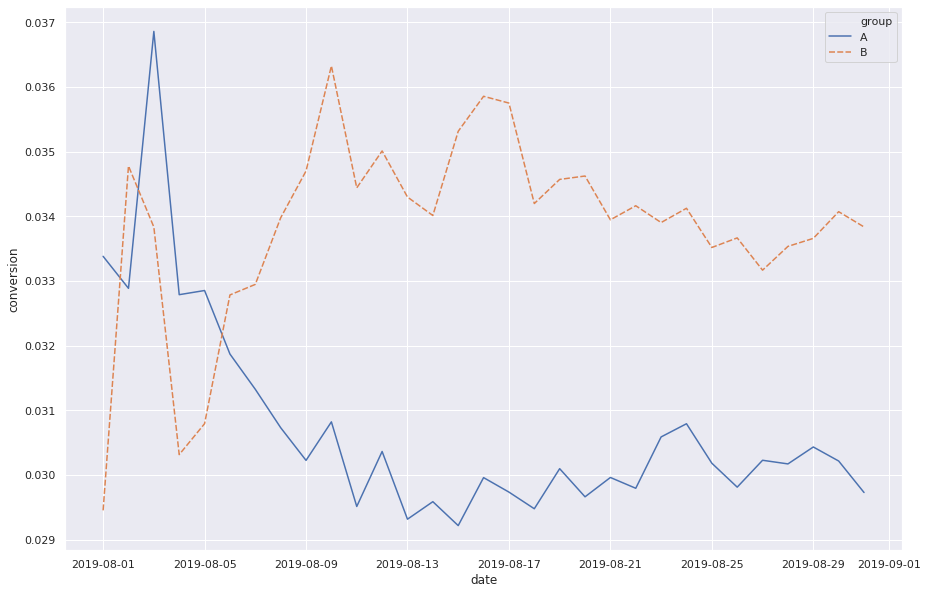

In [43]:
ax = sns.lineplot(x='date', y='conversion', hue = 'group', style = 'group', data = cummulativeData, ci=None)